# Install Dependencies

In [145]:
!pip install tensorflow[and-cuda] kagglehub keras keras_tuner matplotlib scikit-learn

# Import Libraries and Download Dataset

In [146]:
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras import layers
from tensorflow.keras.losses import CategoricalCrossentropy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import kagglehub
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report

In [147]:
path = kagglehub.dataset_download("drgfreeman/rockpaperscissors")

Using Colab cache for faster access to the 'rockpaperscissors' dataset.


In [148]:
print("Tensorflow Version: ", tf.__version__)
print("List of physical devices: ", tf.config.list_physical_devices())

Tensorflow Version:  2.19.0
List of physical devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Utility Functions

In [149]:
def plot_accuracy_loss(history, comp_history=None):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  if comp_history is not None:
    acc_c = comp_history.history['accuracy']
    val_acc_c = comp_history.history['val_accuracy']
    loss_c = comp_history.history['loss']
    val_loss_c = comp_history.history['val_loss']

  fig, axes = plt.subplots(1, 2, figsize=(16, 4))
  axes = axes.flatten()

  epochs_range = range(len(acc))

  # --- Accuracy ---
  axes[0].plot(epochs_range, acc, label='Training', linewidth=2)
  axes[0].plot(epochs_range, val_acc, label='Validation', linewidth=2)
  if comp_history is not None:
    axes[0].plot(epochs_range, acc_c, label='Std Training', color="tab:blue", linestyle="--", linewidth=0.75)
    axes[0].plot(epochs_range, val_acc_c, label='Std Validation', color="tab:orange", linestyle="--", linewidth=0.75)
  axes[0].set_title('Accuracy')
  axes[0].set_ylim(0, 1)
  axes[0].set_xlim(0, len(acc) - 1)
  axes[0].set_xticks(np.arange(0, len(acc), 2))
  axes[0].set_xlabel('Epochs')
  axes[0].grid(True)
  axes[0].legend(loc='lower right')

  # --- Loss ---
  axes[1].plot(epochs_range, loss, label='Training', linewidth=2)
  axes[1].plot(epochs_range, val_loss, label='Validation', linewidth=2)
  if comp_history is not None:
    axes[1].plot(epochs_range, loss_c, label='Std Training', color="tab:blue", linestyle="--", linewidth=0.75)
    axes[1].plot(epochs_range, val_loss_c, label='Std Validation', color="tab:orange", linestyle="--", linewidth=0.75)
  axes[1].set_title('Loss')
  axes[1].set_xlim(0, len(loss) - 1)
  axes[1].set_xticks(np.arange(0, len(loss), 2))
  axes[1].set_xlabel('Epochs')
  axes[1].grid(True)
  axes[1].legend(loc='upper right')

def plot_cm_accuracy_pretty(model, test_norm, train_norm, validation_norm, class_names, normalize='all'):
    # ---------- Predizioni ----------
    probs = model.predict(test_norm, verbose=0)
    y_pred = np.argmax(probs, axis=1)
    y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in test_norm], axis=0)

    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))
    cm_norm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)), normalize=normalize) if normalize else None

    # ---------- Metriche ----------
    # Assunzione: model.evaluate ritorna [loss, accuracy] (tipico). Se hai metriche extra cambia indices.
    loss_tr, acc_tr = model.evaluate(train_norm, verbose=0)
    loss_va, acc_va = model.evaluate(validation_norm, verbose=0)
    loss_te, acc_te = model.evaluate(test_norm, verbose=0)

    labels = ["train", "validation", "test"]
    accs = np.array([acc_tr, acc_va, acc_te]) * 100

    # ---------- Figure ----------
    fig = plt.figure(figsize=(16, 4))
    gs = GridSpec(nrows=1, ncols=5, figure=fig, width_ratios=[2.2, 0.1, 2.7, 0.0, 0.0])

    ax_cm = fig.add_subplot(gs[0, 0])
    ax_bar = fig.add_subplot(gs[0, 2])

    # ---------- Confusion Matrix (heatmap manuale) ----------
    data = cm_norm if cm_norm is not None else cm
    im = ax_cm.imshow(data, interpolation='nearest', cmap='coolwarm')

    # ticks / labels
    ax_cm.set_xticks(np.arange(len(class_names)))
    ax_cm.set_yticks(np.arange(len(class_names)))
    ax_cm.set_xticklabels(class_names, rotation=0)
    ax_cm.set_yticklabels(class_names)
    ax_cm.set_xlabel("Predicted")
    ax_cm.set_ylabel("True")

    title_cm = "Confusion Matrix"
    if normalize:
        title_cm += f" (normalized: {normalize})"
    ax_cm.set_title(title_cm)

    # griglia leggera per leggibilità
    ax_cm.set_xticks(np.arange(-.5, len(class_names), 1), minor=True)
    ax_cm.set_yticks(np.arange(-.5, len(class_names), 1), minor=True)
    ax_cm.grid(which="minor", linestyle="-", linewidth=0.8, alpha=0.25)
    ax_cm.tick_params(which="minor", bottom=False, left=False)

    # annotazioni: percentuale + conteggio
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            cnt = cm[i, j]
            if cm_norm is not None:
                pct = cm_norm[i, j] * 100
                txt = f"{pct:.1f}%\n({cnt})"
            else:
                txt = f"{cnt}"
            ax_cm.text(j, i, txt, ha="center", va="center", fontsize=9)

    # colorbar piccola (opzionale, ma spesso “fa tesi”)
    cbar = fig.colorbar(im, ax=ax_cm, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel("Rate" if normalize else "Count", rotation=90)

    # ---------- Accuracy barplot ----------
    colors = ['tab:blue', 'tab:blue', 'tab:orange']
    bars = ax_bar.bar(labels, accs, color=colors, edgecolor='black', linewidth=0.6)

    ax_bar.set_title("Accuracy by split")
    ax_bar.set_ylabel("Accuracy (%)")
    ax_bar.set_ylim(0, 100)

    # linea di riferimento (es. 80%) se vuoi un “benchmark visivo”
    ax_bar.axhline(80, linewidth=1, alpha=0.35)

    # etichette sopra le barre (più leggibili di padding negativo)
    for b, v in zip(bars, accs):
        ax_bar.text(b.get_x() + b.get_width()/2, v + 1.2, f"{v:.2f}%", ha="center", va="bottom", fontsize=10)

    # pulizia spines / griglia
    ax_bar.grid(axis='y', alpha=0.25)
    ax_bar.spines['top'].set_visible(False)
    ax_bar.spines['right'].set_visible(False)

    plt.show()

def show_report(model, dataset):
  probs = model.predict(dataset)

  y_pred = np.argmax(probs, axis=1)
  y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in dataset], axis=0)

  print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

# Data Loading

In [150]:
SEED = 1
BATCH_SIZE = 32
IMAGE_SIZE = (200, 300)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [151]:
train, holdout = tf.keras.utils.image_dataset_from_directory(
    path,
    labels="inferred",
    label_mode="categorical",
    validation_split=0.3,
    subset="both",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_names=["paper", "scissors", "rock"]
)
holdout_batches = holdout.cardinality().numpy()
if holdout_batches < 0:
    holdout_batches = sum(1 for _ in holdout)
val_batches = holdout_batches // 2
validation = holdout.take(val_batches)
test = holdout.skip(val_batches)
class_names = train.class_names

Found 2188 files belonging to 3 classes.
Using 1532 files for training.
Using 656 files for validation.


## Preview Data

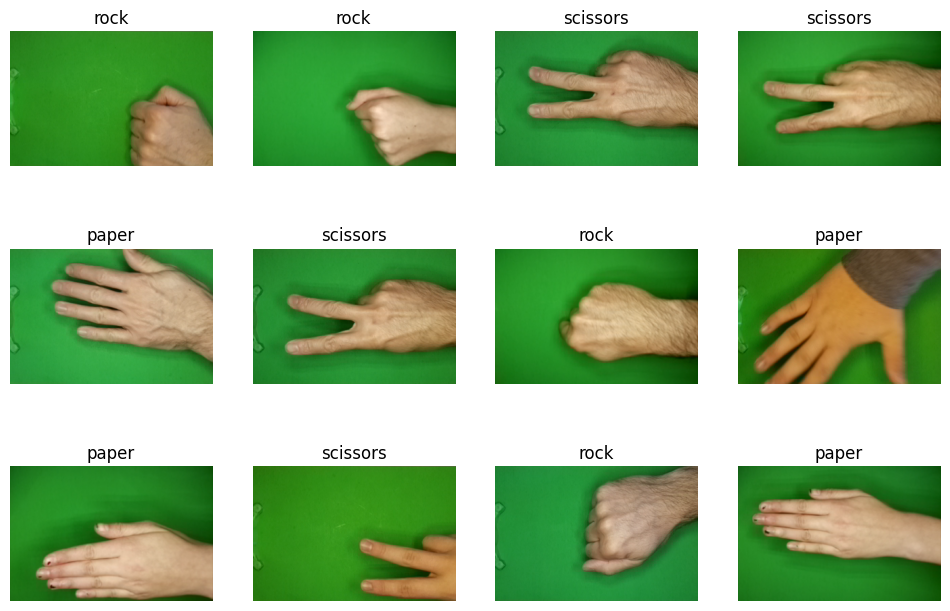

In [152]:
# Get the first batch
images, labels = next(iter(train))

plt.figure(figsize=(12, 8))
for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    label_idx = np.argmax(labels[i])
    plt.title(class_names[label_idx])
    plt.axis('off')

plt.show()

# Preprocessing

In [153]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_norm = train.map(lambda x, y: (normalization_layer(x), y))
validation_norm = validation.map(lambda x, y: (normalization_layer(x), y))
test_norm = test.map(lambda x, y: (normalization_layer(x), y))

# Models

In [154]:
baseline_model = tf.keras.Sequential([
    layers.Input(shape=(200, 300, 3)),
    layers.Conv2D(16, (7, 7), padding="same", activation="relu"),
    layers.MaxPooling2D((3, 3)),
    layers.Conv2D(32, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D((3, 3)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(3, activation="softmax")
])

In [155]:
intermediate_model = tf.keras.Sequential([
    layers.Input(shape=(200, 300, 3)),
    layers.Conv2D(8, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.1),
    layers.Dense(64, activation="relu"),
    layers.Dense(3, activation="softmax")
])

In [156]:
advanced_model = tf.keras.Sequential([
    layers.Input(shape=(200, 300, 3)),
    layers.Conv2D(8, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.25),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.25),
    layers.Dense(64, activation="relu"),
    layers.Dense(3, activation="softmax")
])

In [157]:
baseline_model.compile(
    optimizer="adam",
    loss=CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)
baseline_hist = baseline_model.fit(train_norm, validation_data=validation_norm, epochs=20)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.3194 - loss: 1.1070 - val_accuracy: 0.3031 - val_loss: 1.0962
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3856 - loss: 1.0955 - val_accuracy: 0.3031 - val_loss: 1.0946
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3757 - loss: 1.0851 - val_accuracy: 0.4906 - val_loss: 1.0614
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4698 - loss: 1.0459 - val_accuracy: 0.4500 - val_loss: 1.0219
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5114 - loss: 0.9955 - val_accuracy: 0.4219 - val_loss: 1.0517
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4761 - loss: 0.9972 - val_accuracy: 0.3719 - val_loss: 1.0791
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4892 - loss: 0.9844 - val_accuracy: 0.4781 - val_loss: 1.0221
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5459 - loss: 0.9686 - val_accuracy: 0.5000 - v

In [158]:
intermediate_model.compile(
    optimizer="adam",
    loss=CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)
intermediate_hist = intermediate_model.fit(train_norm, validation_data=validation_norm, epochs=20)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.3146 - loss: 1.0995 - val_accuracy: 0.3875 - val_loss: 1.0829
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4375 - loss: 1.0627 - val_accuracy: 0.4375 - val_loss: 1.0276
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4493 - loss: 1.0264 - val_accuracy: 0.4844 - val_loss: 1.0085
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4782 - loss: 0.9992 - val_accuracy: 0.4500 - val_loss: 0.9856
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4600 - loss: 0.9977 - val_accuracy: 0.4469 - val_loss: 0.9869
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4934 - loss: 0.9717 - val_accuracy: 0.4844 - val_loss: 0.9723
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5163 - loss: 0.9721 - val_accuracy: 0.6313 - val_loss: 0.9629
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5654 - loss: 0.9455 - val_accuracy: 0.4812 - v

In [159]:
advanced_model.compile(
    optimizer="adam",
    loss=CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)
advanced_hist = advanced_model.fit(train_norm, validation_data=validation_norm, epochs=20)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.3320 - loss: 1.0987 - val_accuracy: 0.3656 - val_loss: 1.0926
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4448 - loss: 1.0563 - val_accuracy: 0.4844 - val_loss: 0.9404
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5323 - loss: 0.9009 - val_accuracy: 0.5312 - val_loss: 0.8687
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5488 - loss: 0.9069 - val_accuracy: 0.5750 - val_loss: 0.8407
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6160 - loss: 0.8078 - val_accuracy: 0.5469 - val_loss: 0.8656
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6577 - loss: 0.7545 - val_accuracy: 0.5813 - val_loss: 0.7982
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7924 - loss: 0.5740 - val_accuracy: 0.8813 - val_loss: 0.3917
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8665 - loss: 0.3651 - val_accuracy: 0.9031 -

# Standard Training Results

## Model A

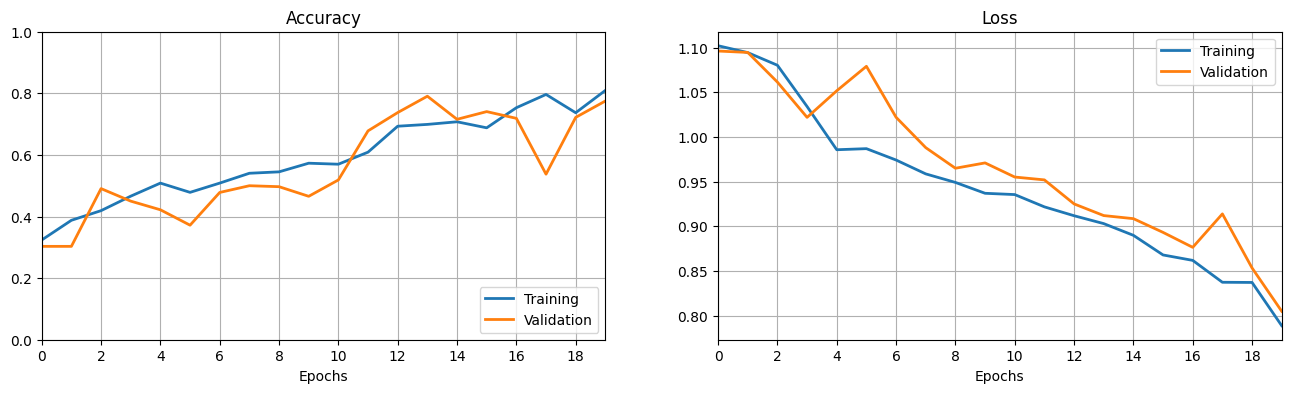

In [160]:
plot_accuracy_loss(baseline_hist)

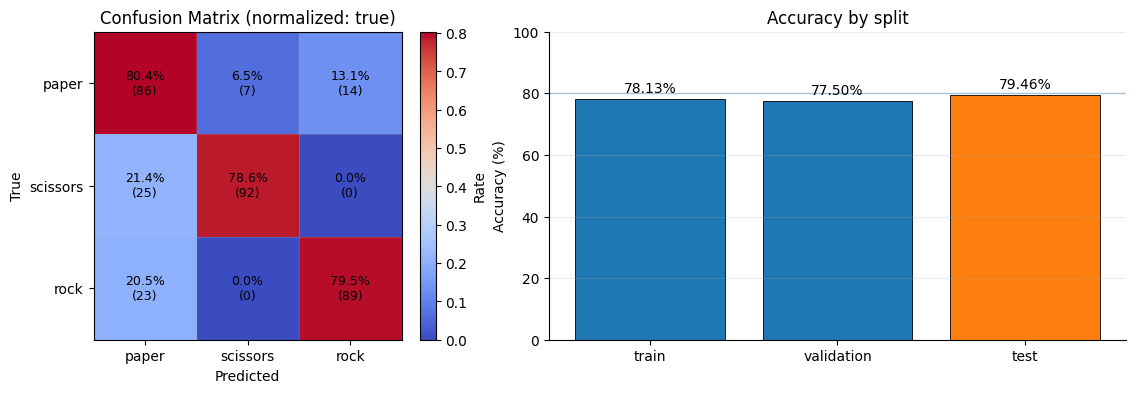

In [161]:
plot_cm_accuracy_pretty(baseline_model, test_norm, train_norm, validation_norm, class_names, normalize='true')

In [162]:
show_report(baseline_model, test_norm)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
              precision    recall  f1-score   support

       paper       0.64      0.80      0.71       107
    scissors       0.93      0.79      0.85       117
        rock       0.86      0.79      0.83       112

    accuracy                           0.79       336
   macro avg       0.81      0.79      0.80       336
weighted avg       0.82      0.79      0.80       336



## Model B

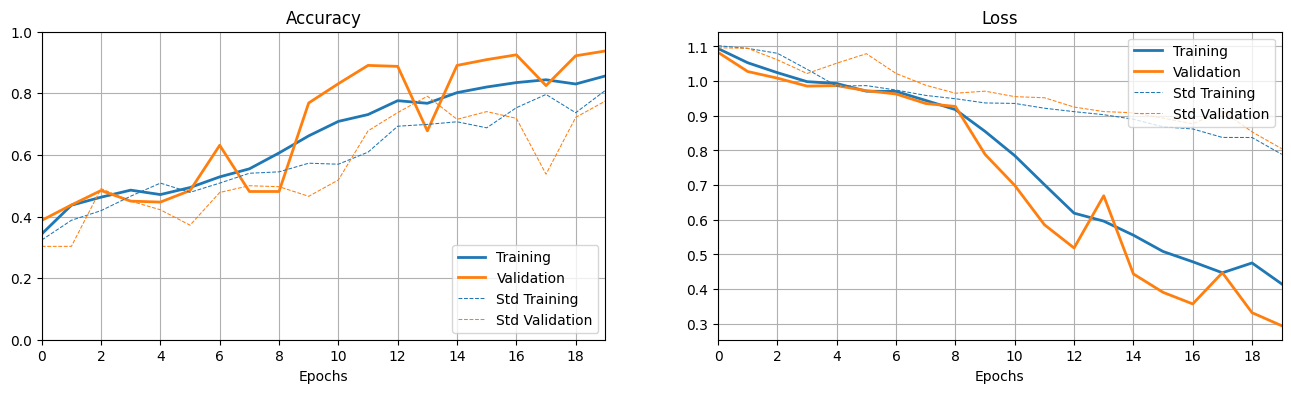

In [163]:
plot_accuracy_loss(intermediate_hist, baseline_hist)

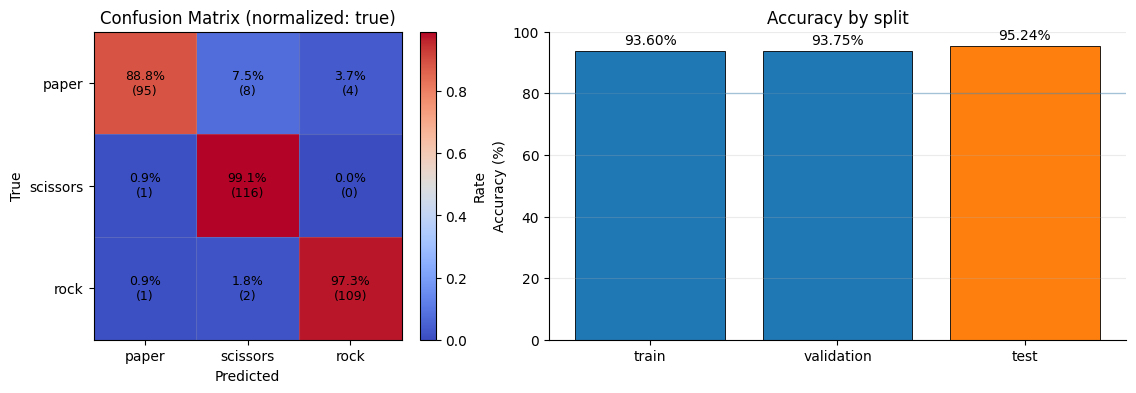

In [164]:
plot_cm_accuracy_pretty(intermediate_model, test_norm, train_norm, validation_norm, class_names, normalize='true')

In [165]:
show_report(intermediate_model, test_norm)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
              precision    recall  f1-score   support

       paper       0.98      0.89      0.93       107
    scissors       0.92      0.99      0.95       117
        rock       0.96      0.97      0.97       112

    accuracy                           0.95       336
   macro avg       0.95      0.95      0.95       336
weighted avg       0.95      0.95      0.95       336



## Model C

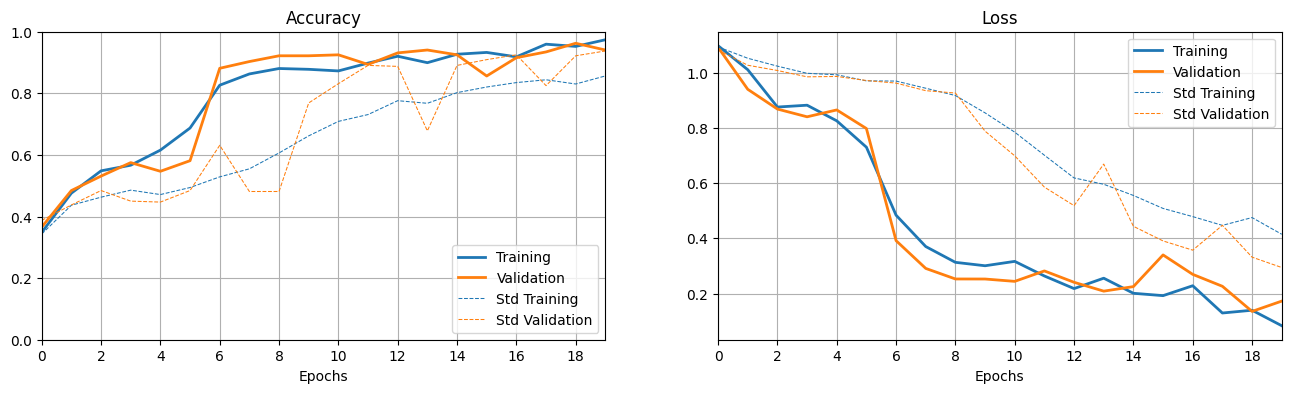

In [166]:
plot_accuracy_loss(advanced_hist, intermediate_hist)

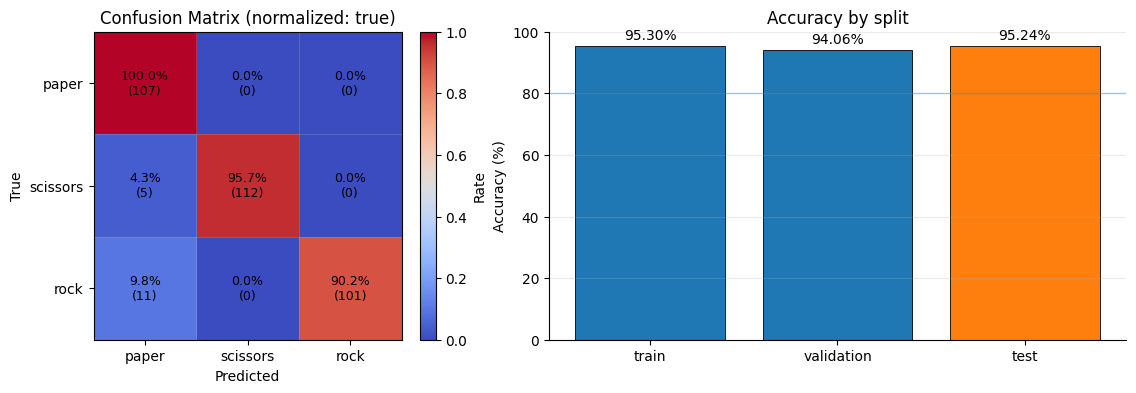

In [167]:
plot_cm_accuracy_pretty(advanced_model, test_norm, train_norm, validation_norm, class_names, normalize='true')

In [168]:
show_report(advanced_model, test_norm)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
              precision    recall  f1-score   support

       paper       0.87      1.00      0.93       107
    scissors       1.00      0.96      0.98       117
        rock       1.00      0.90      0.95       112

    accuracy                           0.95       336
   macro avg       0.96      0.95      0.95       336
weighted avg       0.96      0.95      0.95       336



# Data Augmentation Results

In [169]:
data_augmentation_block = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.08),
        layers.RandomTranslation(0.05, 0.05),
        layers.RandomZoom(0.08),
        layers.RandomContrast(0.10),
    ],
    name="data_augmentation"
)

In [170]:
baseline_data_aug_model = tf.keras.Sequential([
    layers.Input(shape=(200, 300, 3)),
    data_augmentation_block,
    layers.Conv2D(16, (7, 7), padding="same", activation="relu"),
    layers.MaxPooling2D((3, 3)),
    layers.Conv2D(32, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D((3, 3)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(3, activation="softmax")
])

In [171]:
intermediate_data_aug_model = tf.keras.Sequential([
    layers.Input(shape=(200, 300, 3)),
    data_augmentation_block,
    layers.Conv2D(8, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.1),
    layers.Dense(64, activation="relu"),
    layers.Dense(3, activation="softmax")
])

In [172]:
advanced_data_aug_model = tf.keras.Sequential([
    layers.Input(shape=(200, 300, 3)),
    data_augmentation_block,
    layers.Conv2D(8, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.25),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.25),
    layers.Dense(64, activation="relu"),
    layers.Dense(3, activation="softmax")
])

### Compile Models

In [173]:
baseline_data_aug_model.compile(
    optimizer="adam",
    loss=CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)
baseline_data_aug_hist = baseline_data_aug_model.fit(train_norm, validation_data=validation_norm, epochs=20)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.3516 - loss: 1.0991 - val_accuracy: 0.4594 - val_loss: 1.0799
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4231 - loss: 1.0657 - val_accuracy: 0.4844 - val_loss: 1.0378
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4589 - loss: 1.0298 - val_accuracy: 0.3969 - val_loss: 1.0368
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4466 - loss: 1.0162 - val_accuracy: 0.4688 - val_loss: 0.9905
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4986 - loss: 0.9841 - val_accuracy: 0.5531 - val_loss: 0.9808
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5465 - loss: 0.9751 - val_accuracy: 0.4313 - val_loss: 0.9925
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5045 - loss: 0.9709 - val_accuracy: 0.5219 - val_loss: 0.9574
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5337 - loss: 0.9478 - val_accuracy: 0.7031 - v

In [174]:
intermediate_data_aug_model.compile(
    optimizer="adam",
    loss=CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)
intermediate_data_aug_hist = intermediate_data_aug_model.fit(train_norm, validation_data=validation_norm, epochs=20)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.3489 - loss: 1.0964 - val_accuracy: 0.5063 - val_loss: 1.0866
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4471 - loss: 1.0766 - val_accuracy: 0.5031 - val_loss: 1.0369
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4340 - loss: 1.0404 - val_accuracy: 0.3625 - val_loss: 1.0462
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4234 - loss: 1.0396 - val_accuracy: 0.5406 - val_loss: 0.9872
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4957 - loss: 0.9851 - val_accuracy: 0.4531 - val_loss: 0.9782
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5275 - loss: 0.9607 - val_accuracy: 0.6781 - val_loss: 0.9345
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5138 - loss: 0.9599 - val_accuracy: 0.4969 - val_loss: 0.9236
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5628 - loss: 0.9204 - val_accuracy: 0.7656 - v

In [175]:
advanced_data_aug_model.compile(
    optimizer="adam",
    loss=CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)
advanced_data_aug_hist = advanced_data_aug_model.fit(train_norm, validation_data=validation_norm, epochs=20)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.3446 - loss: 1.0986 - val_accuracy: 0.3438 - val_loss: 1.0970
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3545 - loss: 1.0929 - val_accuracy: 0.4031 - val_loss: 1.0280
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4088 - loss: 1.0698 - val_accuracy: 0.4000 - val_loss: 1.0291
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4670 - loss: 1.0121 - val_accuracy: 0.5531 - val_loss: 0.9177
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5036 - loss: 0.9497 - val_accuracy: 0.4938 - val_loss: 0.9089
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5535 - loss: 0.8709 - val_accuracy: 0.6469 - val_loss: 0.8380
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5602 - loss: 0.8648 - val_accuracy: 0.7000 - val_loss: 0.7316
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5874 - loss: 0.8427 - val_accuracy: 0.6719 - v

## Model A

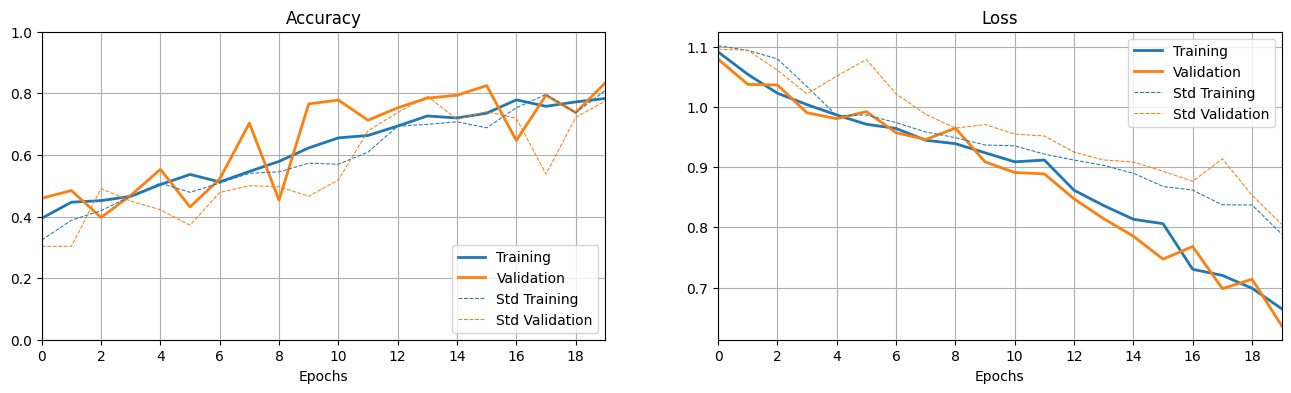

In [176]:
plot_accuracy_loss(baseline_data_aug_hist, baseline_hist)

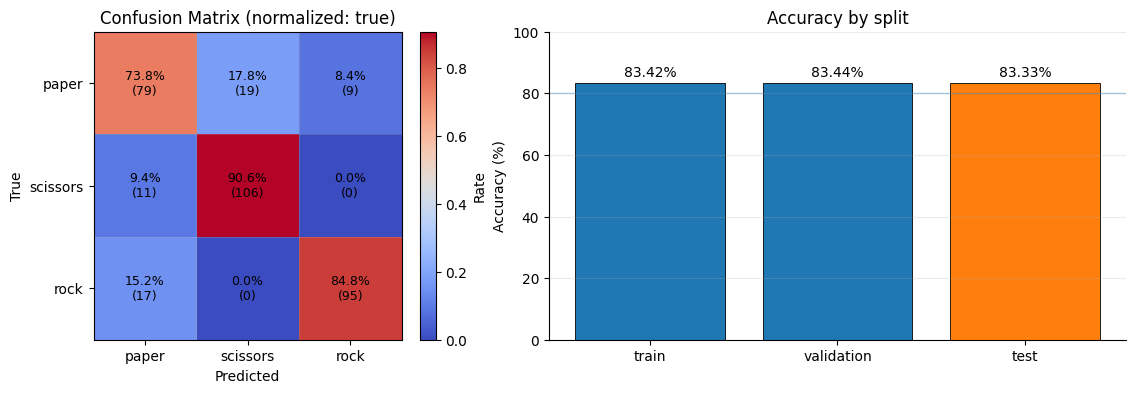

In [177]:
plot_cm_accuracy_pretty(baseline_data_aug_model, test_norm, train_norm, validation_norm, class_names, normalize='true')

In [178]:
show_report(baseline_data_aug_model, test_norm)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
              precision    recall  f1-score   support

       paper       0.74      0.74      0.74       107
    scissors       0.85      0.91      0.88       117
        rock       0.91      0.85      0.88       112

    accuracy                           0.83       336
   macro avg       0.83      0.83      0.83       336
weighted avg       0.83      0.83      0.83       336



## Model B

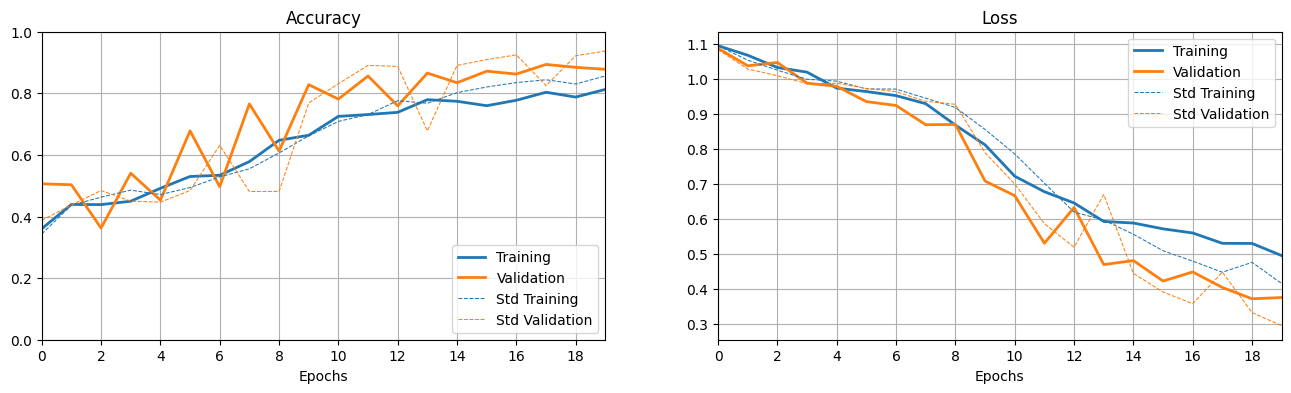

In [179]:
plot_accuracy_loss(intermediate_data_aug_hist, intermediate_hist)

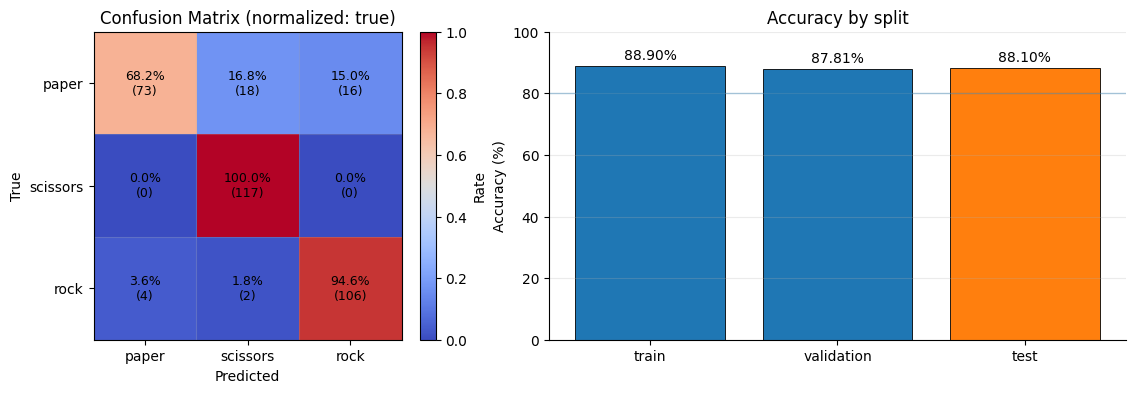

In [180]:
plot_cm_accuracy_pretty(intermediate_data_aug_model, test_norm, train_norm, validation_norm, class_names, normalize='true')

In [181]:
show_report(intermediate_data_aug_model, test_norm)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
              precision    recall  f1-score   support

       paper       0.95      0.68      0.79       107
    scissors       0.85      1.00      0.92       117
        rock       0.87      0.95      0.91       112

    accuracy                           0.88       336
   macro avg       0.89      0.88      0.87       336
weighted avg       0.89      0.88      0.88       336



## Model C

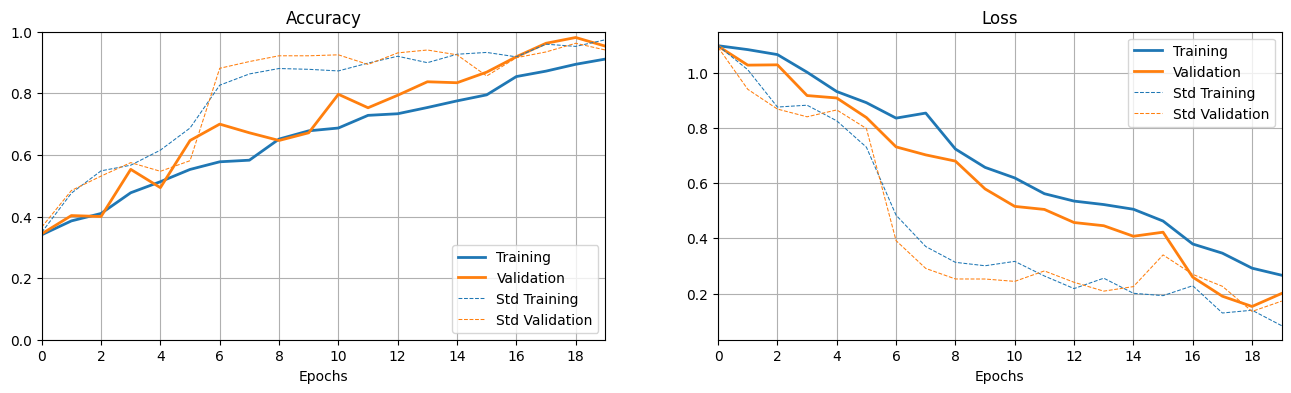

In [182]:
plot_accuracy_loss(advanced_data_aug_hist, advanced_hist)

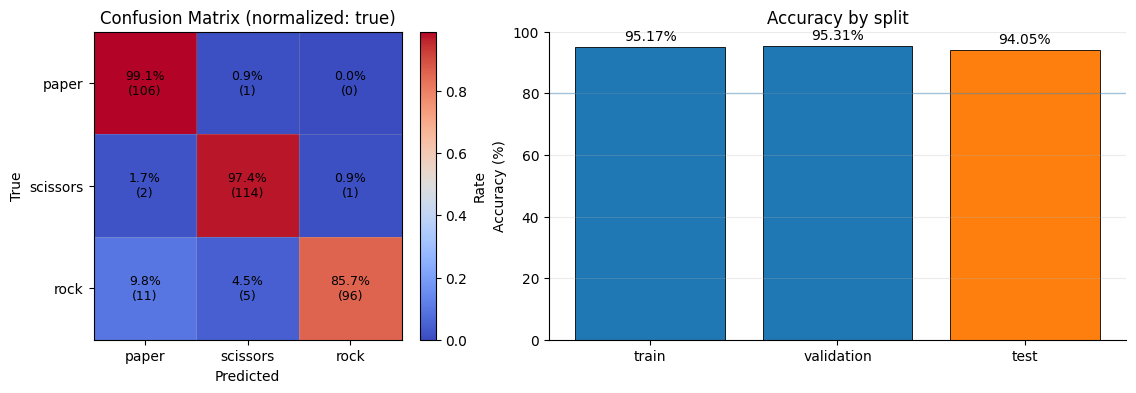

In [183]:
plot_cm_accuracy_pretty(advanced_data_aug_model, test_norm, train_norm, validation_norm, class_names, normalize='true')

In [184]:
show_report(advanced_data_aug_model, test_norm)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
              precision    recall  f1-score   support

       paper       0.89      0.99      0.94       107
    scissors       0.95      0.97      0.96       117
        rock       0.99      0.86      0.92       112

    accuracy                           0.94       336
   macro avg       0.94      0.94      0.94       336
weighted avg       0.94      0.94      0.94       336



# Hyperparameter Tuning

In [185]:
def build_model(hp):
    # Hyperparameters
    f1 = hp.Choice("filters_1", [8, 16, 32])
    f2 = hp.Choice("filters_2", [16, 32, 64])
    f3 = hp.Choice("filters_3", [32, 64, 128])
    dropout = hp.Float("dropout", 0.0, 0.5, step=0.1)
    dense_units = hp.Choice("dense_units", [32, 64, 128, 256])
    lr = hp.Float("lr", 1e-4, 3e-3, sampling="log")
    # Model
    model = tf.keras.Sequential([
        layers.Input(shape=(200, 300, 3)),
        layers.Conv2D(f1, (3, 3), padding="same", activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(f2, (3, 3), padding="same", activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(f3, (3, 3), padding="same", activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(dropout),
        layers.Dense(dense_units, activation="relu"),
        layers.Dense(3, activation="softmax")
    ])
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
        loss = CategoricalCrossentropy(from_logits=False),
        metrics = ['accuracy'],
    )
    return model

In [186]:
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=20,          # quante configurazioni provare
    executions_per_trial=1, # 1 training per configurazione
    directory="tune",
    project_name="model_b_random",
    overwrite=True
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=5,
        restore_best_weights=True
    )
]

tuner.search(
    train_norm,
    validation_data=validation_norm,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

Trial 20 Complete [00h 00m 26s]
val_accuracy: 0.871874988079071

Best val_accuracy So Far: 0.984375
Total elapsed time: 00h 07m 55s


In [187]:
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best hyperparameters:")
print(best_hp.values)


Best hyperparameters:
{'filters_1': 16, 'filters_2': 64, 'filters_3': 64, 'dropout': 0.30000000000000004, 'dense_units': 32, 'lr': 0.0018884790602105843}


Test_Finale

In [188]:
intermediate_ht_model = tuner.hypermodel.build(best_hp)

intermediate_ht_hist = intermediate_ht_model.fit(
    train_norm,
    validation_data=validation_norm,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.3488 - loss: 1.1019 - val_accuracy: 0.3438 - val_loss: 1.0816
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3878 - loss: 1.0788 - val_accuracy: 0.3656 - val_loss: 1.0471
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4331 - loss: 1.0290 - val_accuracy: 0.4156 - val_loss: 0.9953
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4631 - loss: 1.0207 - val_accuracy: 0.4187 - val_loss: 0.9884
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4432 - loss: 0.9645 - val_accuracy: 0.5219 - val_loss: 0.9114
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5134 - loss: 0.9189 - val_accuracy: 0.6531 - val_loss: 0.8026
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5866 - loss: 0.8125 - val_accuracy: 0.6500 - val_loss: 0.7141
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6564 - loss: 0.6831 - val_accuracy: 0.5875 - v

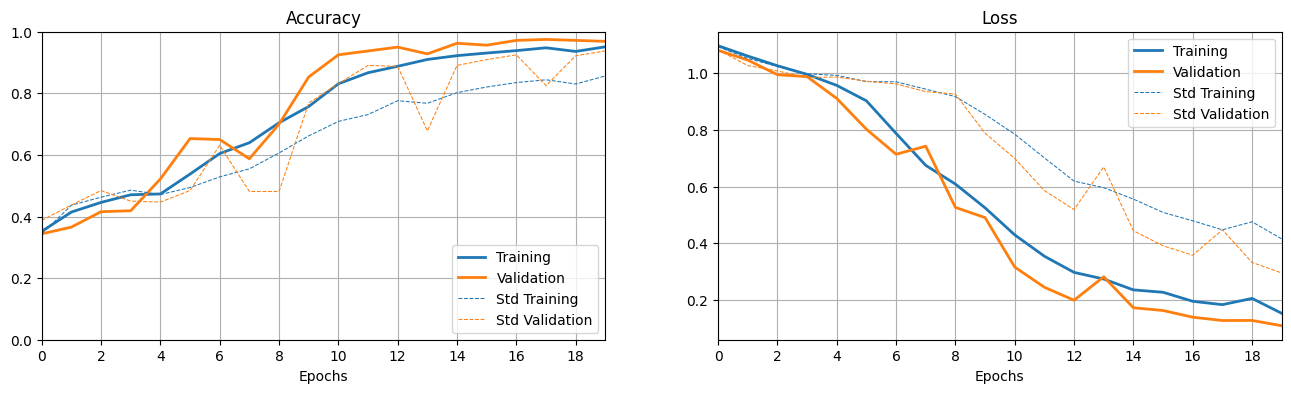

In [189]:
plot_accuracy_loss(intermediate_ht_hist, intermediate_hist)

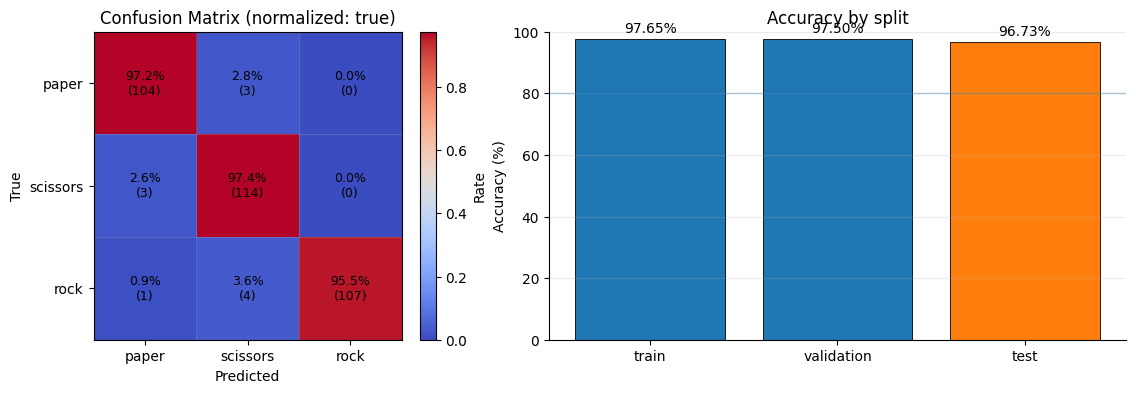

In [190]:
plot_cm_accuracy_pretty(intermediate_ht_model, test_norm, train_norm, validation_norm, class_names, normalize='true')

In [191]:
show_report(intermediate_ht_model, test_norm)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
              precision    recall  f1-score   support

       paper       0.96      0.97      0.97       107
    scissors       0.94      0.97      0.96       117
        rock       1.00      0.96      0.98       112

    accuracy                           0.97       336
   macro avg       0.97      0.97      0.97       336
weighted avg       0.97      0.97      0.97       336

